In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import requests
import seaborn as sns
import arviz as az
from scipy import integrate, stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ, likelihood / scale_factor, lw=4, color="b", label="likelihood scaled", alpha=0.2
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

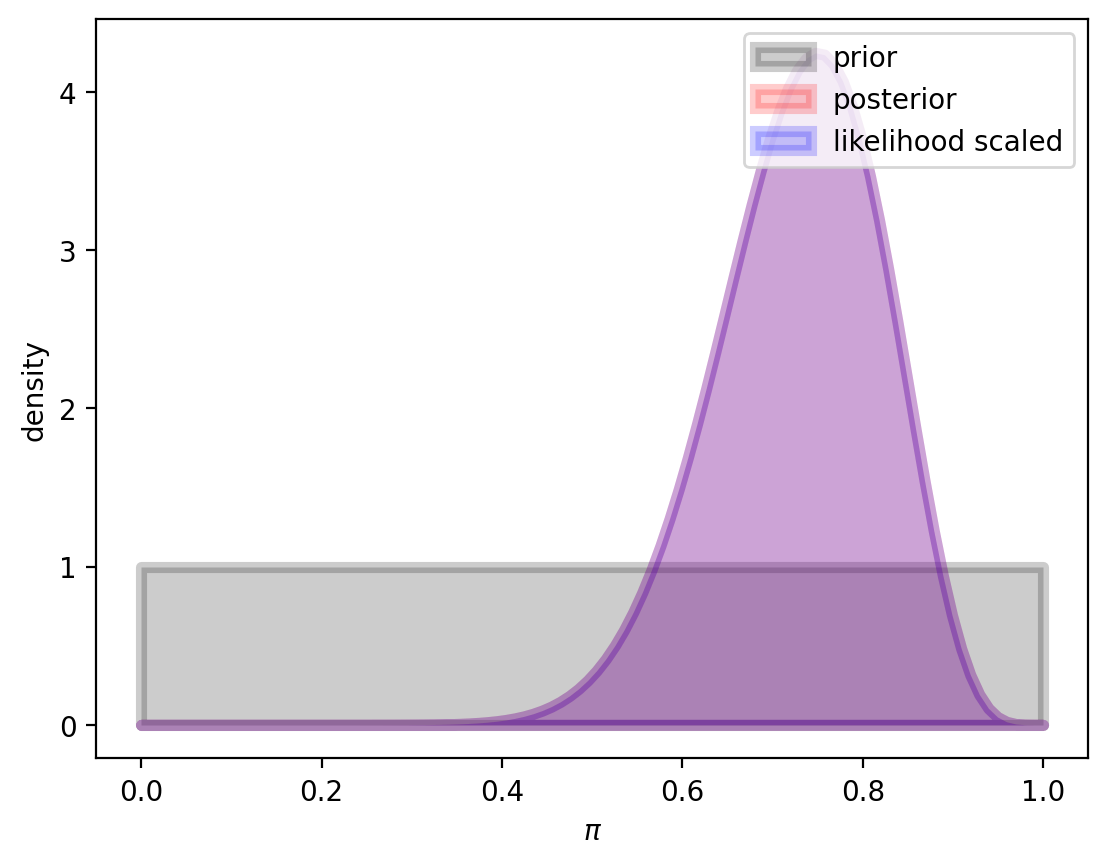

In [4]:
plot_beta_binomial(alpha=1, beta=1, y=15, n=20)

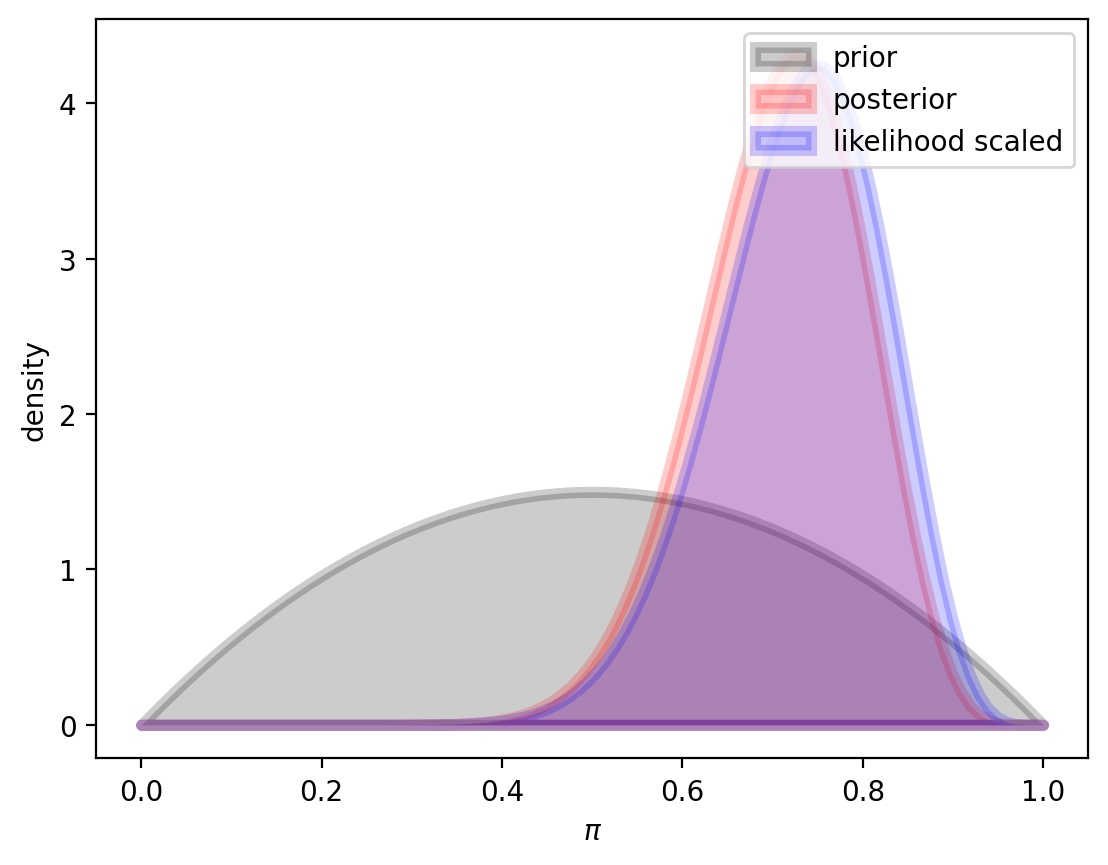

In [5]:
plot_beta_binomial(alpha=2, beta=2, y=15, n=20)

In [6]:
summarize_beta_binomial(alpha=2, beta=2, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,17,7,0.708333,0.727273,0.008264,0.090906


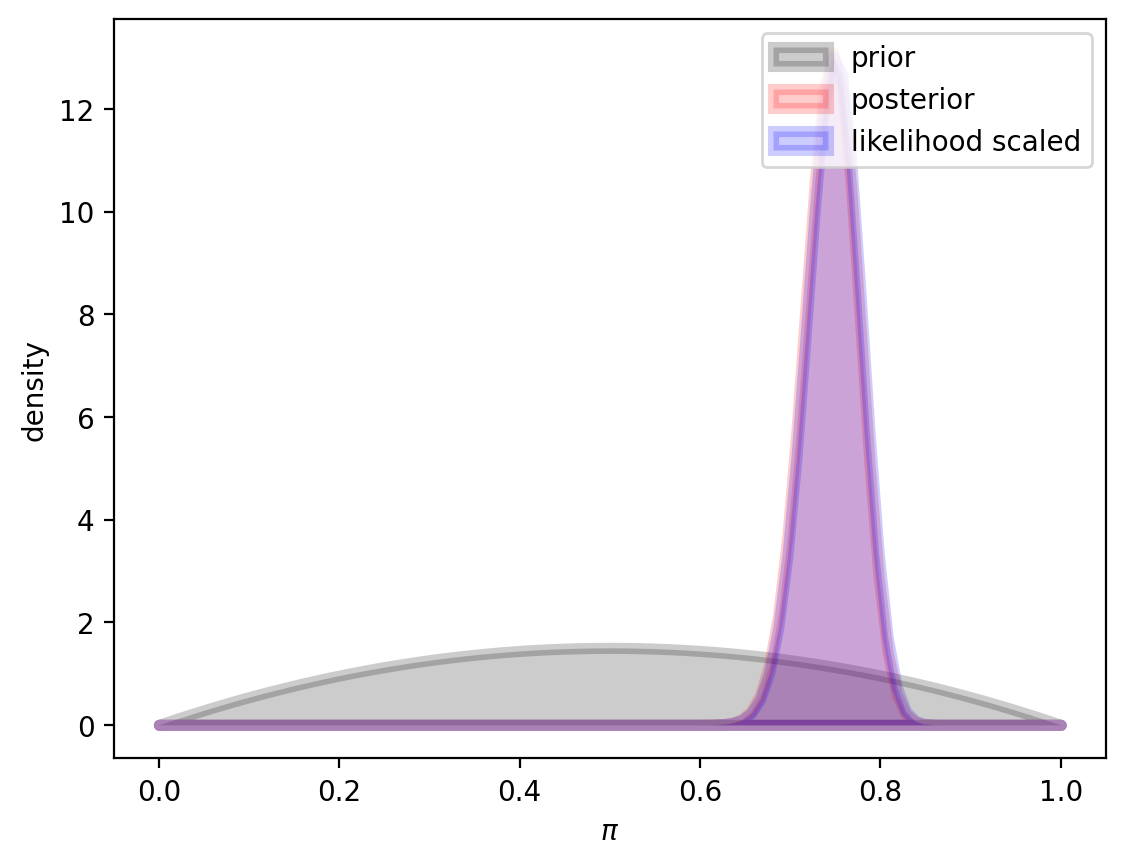

In [7]:
plot_beta_binomial(alpha=2, beta=2, y=150, n=200)

In [8]:
summarize_beta_binomial(alpha=2, beta=2, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,152,52,0.745098,0.747525,0.000926,0.030438


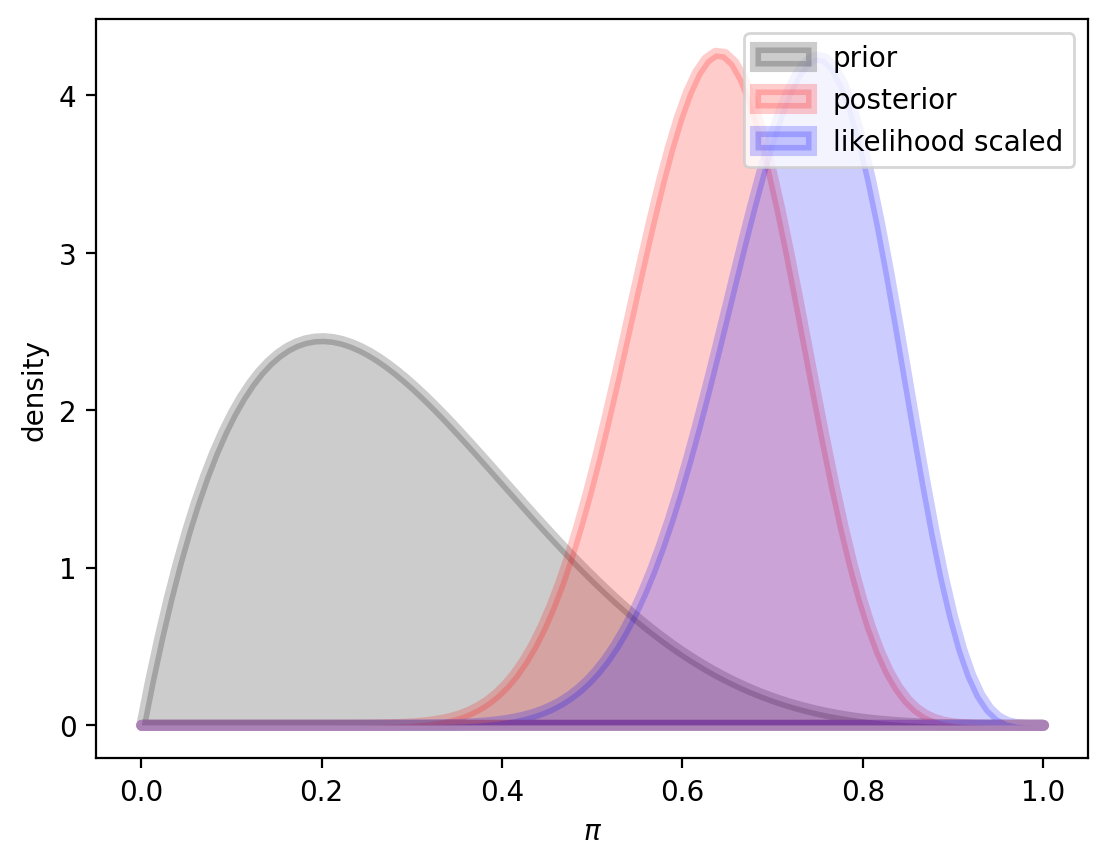

In [9]:
plot_beta_binomial(alpha=2, beta=5, y=15, n=20)

In [10]:
summarize_beta_binomial(alpha=2, beta=5, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.20,0.025510,0.159719
posterior,17,10,0.629630,0.64,0.008328,0.091260


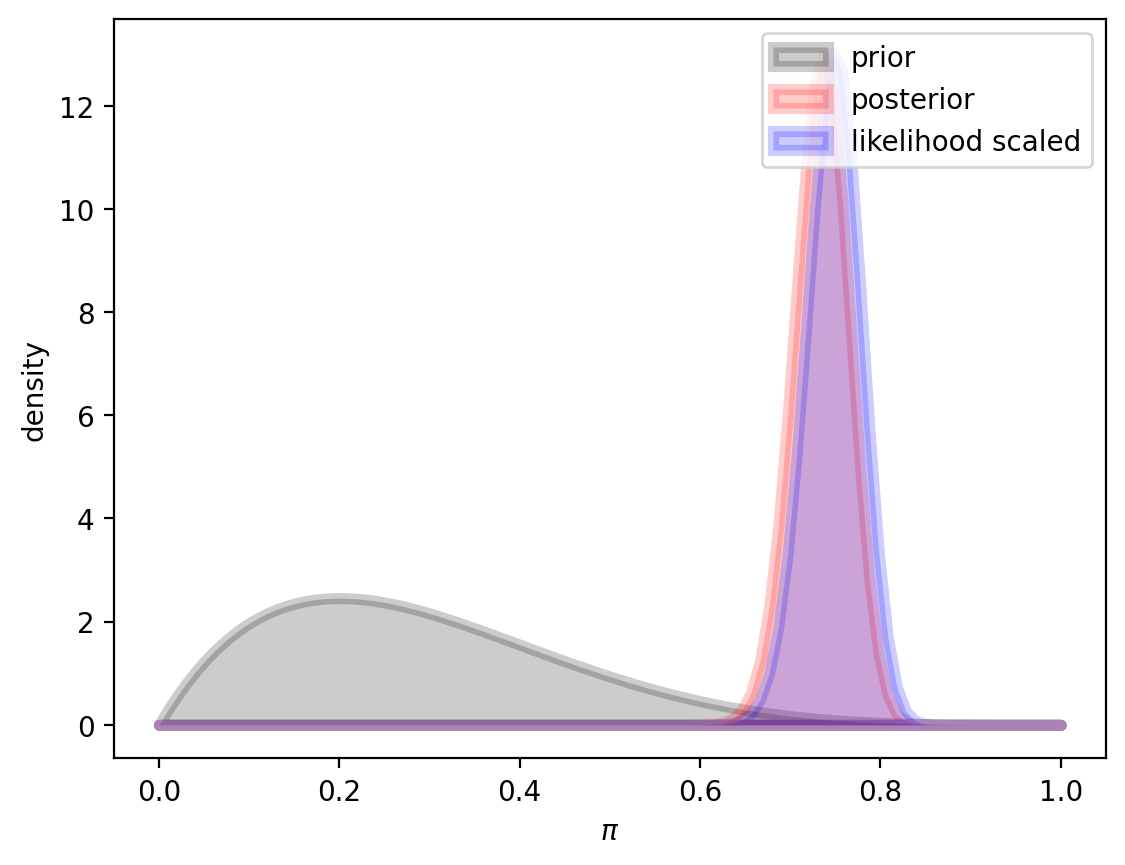

In [11]:
plot_beta_binomial(alpha=2, beta=5, y=150, n=200)

In [12]:
summarize_beta_binomial(alpha=2, beta=5, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,152,55,0.734300,0.736585,0.000938,0.030627


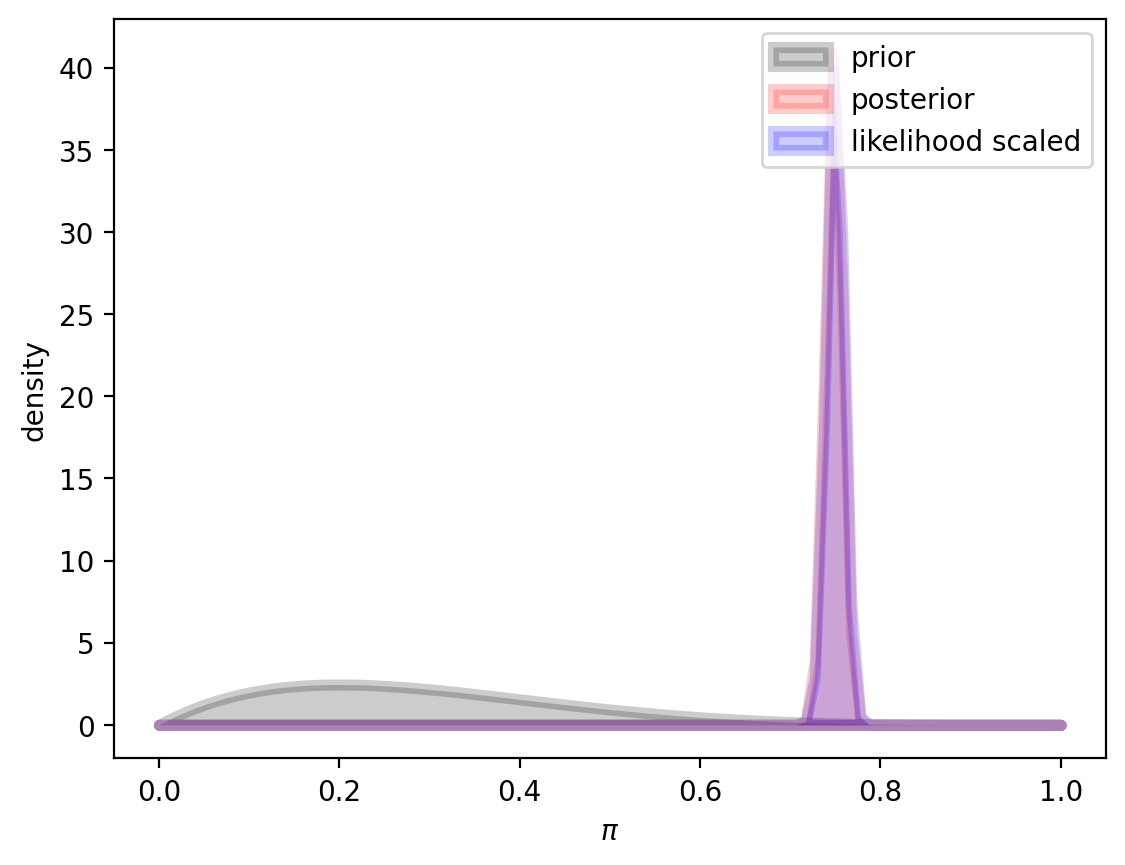

In [13]:
plot_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

In [14]:
summarize_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,1502,505,0.748381,0.748628,0.000094,0.009684


In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

scipy     : 1.10.1
pandas    : 2.0.3
matplotlib: 3.7.2
arviz     : 0.16.0
numpy     : 1.25.2
seaborn   : 0.12.2
pymc      : 5.6.1
requests  : 2.31.0

Watermark: 2.4.3

